In [1]:
import json 
import tensorflow as tf
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score
from tensorflow.keras import backend as K
from keras.models import Model
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint
from keras.layers import Input, Dense, Embedding, Conv1D, Conv2D, MaxPooling1D, MaxPool2D, LSTM
from keras.layers import Reshape, Flatten, Dropout, Concatenate
from keras.layers import SpatialDropout1D, concatenate, BatchNormalization
from keras.layers import GRU, Bidirectional, GlobalAveragePooling1D, GlobalMaxPooling1D
from keras.callbacks import Callback
from keras.optimizers import Adam
from keras.utils import plot_model

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Importer les Train et test pour les titres & abstract 

In [2]:
data_dir = "data/abstract_title"
feature_1 = "abstract"
feature_2 = "title"
label = "label"
x_train_abs = pd.read_csv(f"{data_dir}/train.csv")[feature_1]
x_train_tit = pd.read_csv(f"{data_dir}/train.csv")[feature_2]
y_train = pd.read_csv(f"{data_dir}/train.csv")[label]

x_test_abs = pd.read_csv(f"{data_dir}/test.csv")[feature_1]
x_test_tit = pd.read_csv(f"{data_dir}/test.csv")[feature_2]
y_test = pd.read_csv(f"{data_dir}/test.csv")[label]

x_train_abs.shape,x_train_tit.shape, y_train.shape, x_test_abs.shape, y_test.shape

((8000,), (8000,), (8000,), (2000,), (2000,))

In [3]:
#une fonction pour visualiser accuracy et loss
def plot_history(history, metric="acc"):
    # summarize history for accuracy
    plt.plot(history.history[metric])
    plt.plot(history.history[f'val_{metric}'])
    plt.title(f'model {metric}')
    plt.ylabel(metric)
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [4]:
def create_vocab(dt): 
  to_id = {'<PAD>': 0, '<UNK>':1}

  for sent in dt:
    for w in sent: 
      if w not in to_id.keys():
        to_id[w] = len(to_id)

  from_id = {v: k for k, v in to_id.items()}

  vocab = len(to_id.keys())

  return to_id, from_id, vocab

def preprocess_Y(Y, cat_to_id): 
  res = []
  for ex in Y: 
    if ex not in cat_to_id.keys():
      res.append(cat_to_id['<UNK>'])
    else:
      res.append(cat_to_id[ex])
  return np.array(res)

In [5]:
#manipulation label 
cat_to_id, cat_from_id, cat_vocab = create_vocab([y_train])
y_train_id = preprocess_Y(y_train, cat_to_id)
y_test_id = preprocess_Y(y_test, cat_to_id)
#manipulation features
#Pour x= titre

tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=10000)
tokenizer.fit_on_texts(x_train_tit)
x_train_tit_seq = tokenizer.texts_to_sequences(x_train_tit)
x_test_tit_seq =  tokenizer.texts_to_sequences(x_test_tit)
x_train_tit_seq = tf.keras.preprocessing.sequence.pad_sequences(x_train_tit_seq, maxlen = 40, truncating='post')
x_test_tit_seq = tf.keras.preprocessing.sequence.pad_sequences(x_test_tit_seq, maxlen = 40, truncating='post')

#Pour x=abstract
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=10000)
tokenizer.fit_on_texts(x_train_abs)
x_train_abs_seq = tokenizer.texts_to_sequences(x_train_abs)
x_test_abs_seq =  tokenizer.texts_to_sequences(x_test_abs)
x_train_abs_seq = tf.keras.preprocessing.sequence.pad_sequences(x_train_abs_seq, maxlen = 888, truncating='post')
x_test_abs_seq = tf.keras.preprocessing.sequence.pad_sequences(x_test_abs_seq, maxlen = 888, truncating='post')

In [6]:
# Fonction permettant de charger un embedding 

import numpy as np
import re
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')

def load_glove_embeddings(fp, embedding_dim, include_empty_char=True):
    """
    Loads pre-trained word embeddings (GloVe embeddings)
        Inputs: - fp: filepath of pre-trained glove embeddings
                - embedding_dim: dimension of each vector embedding
                - generate_matrix: whether to generate an embedding matrix
        Outputs:
                - word2coefs: Dictionary. Word to its corresponding coefficients
                - word2index: Dictionary. Word to word-index
                - embedding_matrix: Embedding matrix for Keras Embedding layer
    """
    # First, build the "word2coefs" and "word2index"
    word2coefs = {} # word to its corresponding coefficients
    word2index = {} # word to word-index
    with open(fp) as f:
        for idx, line in enumerate(f):
            try:
                data = [x.strip().lower() for x in line.split()]
                word = data[0]
                coefs = np.asarray(data[1:embedding_dim+1], dtype='float32')
                word2coefs[word] = coefs
                if word not in word2index:
                    word2index[word] = len(word2index)
            except Exception as e:
                print('Exception occurred in `load_glove_embeddings`:', e)
                continue
        # End of for loop.
    # End of with open
    if include_empty_char:
        word2index[''] = len(word2index)
    # Second, build the "embedding_matrix"
    # Words not found in embedding index will be all-zeros. Hence, the "+1".
    vocab_size = len(word2coefs)+1 if include_empty_char else len(word2coefs)
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    for word, idx in word2index.items():
        embedding_vec = word2coefs.get(word)
        if embedding_vec is not None and embedding_vec.shape[0]==embedding_dim:
            embedding_matrix[idx] = np.asarray(embedding_vec)
    # return word2coefs, word2index, embedding_matrix
    return word2index, np.asarray(embedding_matrix)

[nltk_data] Downloading package punkt to /home/ahlem/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [7]:
# Charger les embeddings à l'aide de la fonction load_glove_embeddings

word2index, embedding_matrix = load_glove_embeddings('glove.6B.50d.txt', embedding_dim=50)

In [8]:
# ecrire une fonction de tokenization custom pour preprocesser les textes

def custom_tokenize(doc):
  res = []
  for ex in word_tokenize(doc): 
    if ex not in word2index.keys():
      res.append(word2index['unk'])
    else:
      res.append(word2index[ex])
  return np.array(res)
    
# Encoder les textes avec la fonction custom
X_train_tit_glove = [custom_tokenize(x) for x in x_train_tit]

X_train_abs_glove = [custom_tokenize(x) for x in x_train_abs]


X_test_tit_glove = [custom_tokenize(x) for x in x_test_tit]
X_test_abs_glove = [custom_tokenize(x) for x in x_test_abs]

# Padding des sequences

X_train_tit_glove = tf.keras.preprocessing.sequence.pad_sequences(X_train_tit_glove, maxlen = 40, truncating='post')
X_train_abs_glove = tf.keras.preprocessing.sequence.pad_sequences(X_train_abs_glove, maxlen = 888, truncating='post')
X_test_tit_glove = tf.keras.preprocessing.sequence.pad_sequences(X_test_tit_glove, maxlen = 40, truncating='post')
X_test_abs_glove = tf.keras.preprocessing.sequence.pad_sequences(X_test_abs_glove, maxlen = 888, truncating='post')


# CNN sur les titres et CNN sur les abstracts:
## Embedding GloVe

In [16]:
def concat_cnn(activation='relu'):
    embed_dim = 128
    # Defining input 1
    title_input = Input((40,))
    title_embed = Embedding(embedding_matrix.shape[0], embedding_matrix.shape[1],input_length = 40,
                                    weights=[embedding_matrix], 
                              trainable=True)(title_input)
    
    cnn1 = Conv1D(256, 2, padding='valid', activation=activation, strides=1)(title_embed)
    maxpooled1 = GlobalMaxPooling1D()(cnn1)

    # Defining input 2
    abstract_input = Input((888,))    
    abstract_embed = Embedding(embedding_matrix.shape[0], embedding_matrix.shape[1],input_length = 888,
                                    weights=[embedding_matrix], 
                              trainable=True)(abstract_input)
    
    cnn2 = Conv1D(256, 2, padding='valid', activation=activation, strides=1)(abstract_embed)
    maxpooled2 = GlobalMaxPooling1D()(cnn2)

    # Merging subnetworks
    combined = Concatenate()([maxpooled1, maxpooled2])

    # Final Dense layer and compilation
    output = Dense(cat_vocab, activation='softmax')(combined)
    model = Model(inputs=[title_input, abstract_input], outputs= output)
    adam = Adam(lr=1e-3, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    model.compile(loss='sparse_categorical_crossentropy', optimizer=adam,  metrics=['accuracy'])
    return model
model=concat_cnn()
print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 40)           0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            (None, 888)          0                                            
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 40, 50)       20000050    input_5[0][0]                    
__________________________________________________________________________________________________
embedding_6 (Embedding)         (None, 888, 50)      20000050    input_6[0][0]                    
__________________________________________________________________________________________________
conv1d_5 (

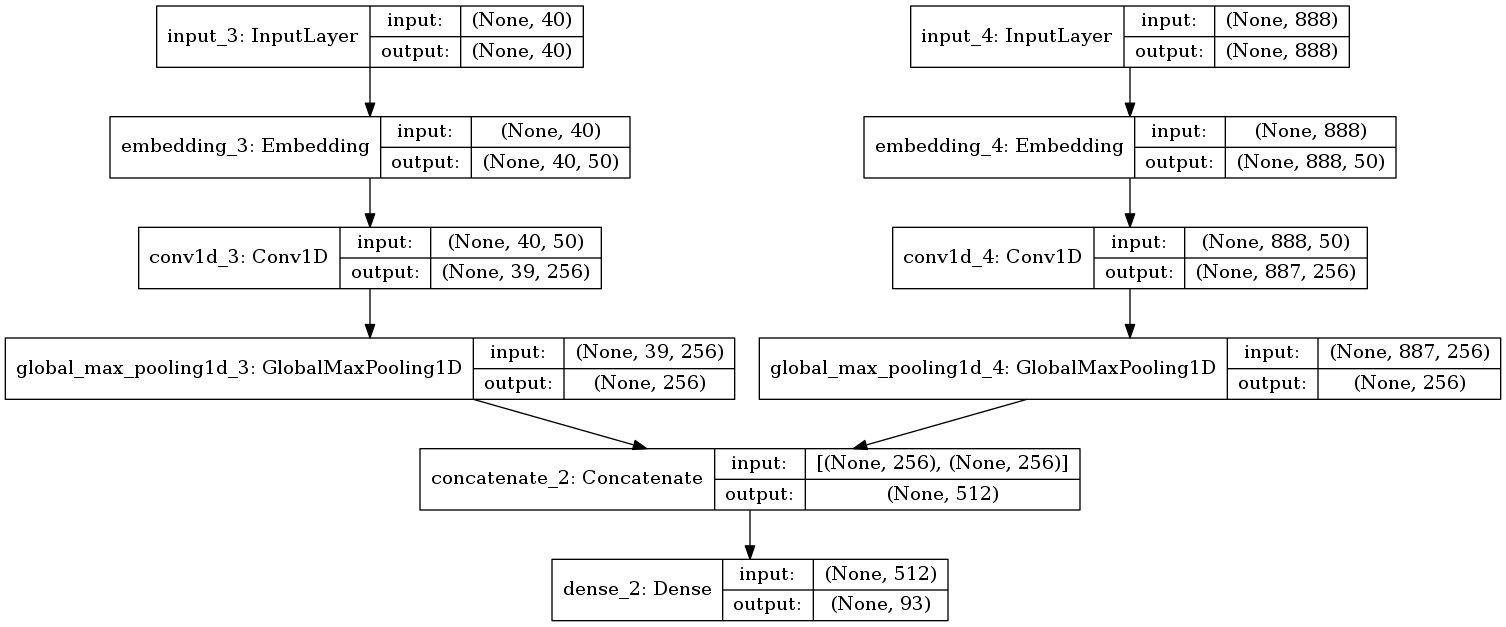

In [13]:
plot_model(model, show_shapes=True, show_layer_names=True, to_file='concat_model.png')
from IPython.display import Image
Image(retina=True, filename='concat_model.png')

In [17]:
batch_size = 128
epochs = 12
history = model.fit([X_train_tit_glove,X_train_abs_glove] , 
                    y=y_train_id, 
                    batch_size=batch_size, 
                    validation_data=([X_test_tit_glove,X_test_abs_glove], y_test_id),
                    epochs=epochs)

Train on 8000 samples, validate on 2000 samples
Epoch 1/12
8000/8000 [==============================] - 3s 386us/step - loss: 3.3189 - acc: 0.2482 - val_loss: 2.9372 - val_acc: 0.3055
Epoch 2/12
8000/8000 [==============================] - 2s 249us/step - loss: 2.6424 - acc: 0.3608 - val_loss: 2.5892 - val_acc: 0.3815
Epoch 3/12
8000/8000 [==============================] - 2s 249us/step - loss: 2.2625 - acc: 0.4269 - val_loss: 2.3861 - val_acc: 0.4000
Epoch 4/12
8000/8000 [==============================] - 2s 248us/step - loss: 1.9843 - acc: 0.4845 - val_loss: 2.2698 - val_acc: 0.4160
Epoch 5/12
8000/8000 [==============================] - 2s 249us/step - loss: 1.7539 - acc: 0.5413 - val_loss: 2.1884 - val_acc: 0.4160
Epoch 6/12
8000/8000 [==============================] - 2s 248us/step - loss: 1.5512 - acc: 0.5880 - val_loss: 2.1280 - val_acc: 0.4265
Epoch 7/12
8000/8000 [==============================] - 2s 249us/step - loss: 1.3485 - acc: 0.6490 - val_loss: 2.0541 - val_acc: 0.4495


# LSTM sur les titres et LSTM sur les abstracts:
## Embedding GloVe

In [18]:
def concat_LSTM(activation='relu'):
    embed_dim = 128
    # Defining input 1
    title_input = Input((40,))
    title_embed = Embedding(embedding_matrix.shape[0], embedding_matrix.shape[1],input_length = 40,
                                    weights=[embedding_matrix], 
                              trainable=True)(title_input)
    title_embed_dpout= Dropout(0.3)(title_embed)
    model_1=LSTM(128)(title_embed_dpout)
    
    # Defining input 2
    abstract_input = Input((888,))    
    abstract_embed = Embedding(embedding_matrix.shape[0], embedding_matrix.shape[1],input_length = 888,
                                    weights=[embedding_matrix], 
                              trainable=True)(abstract_input)
    abstract_embed_dpout= Dropout(0.3)(abstract_embed)
    model_2=LSTM(128)(abstract_embed_dpout)

    # Merging subnetworks
    combined = Concatenate()([model_1, model_2])

    # Final Dense layer and compilation
    output = Dense(cat_vocab, activation='softmax')(combined)
    model = Model(inputs=[title_input, abstract_input], outputs= output)
    adam = Adam(lr=1e-3, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    model.compile(loss='sparse_categorical_crossentropy', optimizer=adam,  metrics=['accuracy'])
    return model
model=concat_LSTM()
print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 40)           0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            (None, 888)          0                                            
__________________________________________________________________________________________________
embedding_7 (Embedding)         (None, 40, 50)       20000050    input_7[0][0]                    
__________________________________________________________________________________________________
embedding_8 (Embedding)         (None, 888, 50)      20000050    input_8[0][0]                    
__________________________________________________________________________________________________
dropout_1 

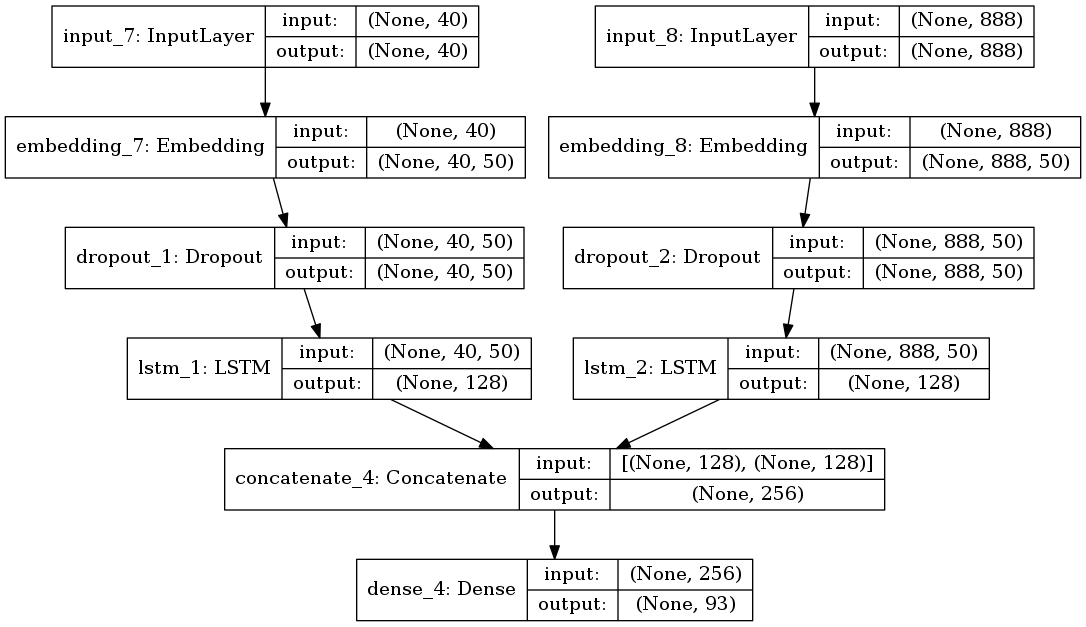

In [19]:
plot_model(model, show_shapes=True, show_layer_names=True, to_file='concat_model_LSTM.png')
from IPython.display import Image
Image(retina=True, filename='concat_model_LSTM.png')

In [20]:
batch_size = 256
epochs = 10
history = model.fit([X_train_tit_glove,X_train_abs_glove] , 
                    y=y_train_id, 
                    batch_size=batch_size, 
                    validation_data=([X_test_tit_glove,X_test_abs_glove], y_test_id),
                    epochs=epochs)

Train on 8000 samples, validate on 2000 samples
Epoch 1/10
8000/8000 [==============================] - 27s 3ms/step - loss: 3.6969 - acc: 0.1736 - val_loss: 3.4005 - val_acc: 0.1900
Epoch 2/10
8000/8000 [==============================] - 25s 3ms/step - loss: 3.2460 - acc: 0.2270 - val_loss: 3.0909 - val_acc: 0.2390
Epoch 3/10
8000/8000 [==============================] - 25s 3ms/step - loss: 2.9828 - acc: 0.2724 - val_loss: 2.8433 - val_acc: 0.2960
Epoch 4/10
8000/8000 [==============================] - 25s 3ms/step - loss: 2.7242 - acc: 0.3135 - val_loss: 2.6718 - val_acc: 0.3220
Epoch 5/10
8000/8000 [==============================] - 25s 3ms/step - loss: 2.5661 - acc: 0.3371 - val_loss: 2.6031 - val_acc: 0.3310
Epoch 6/10
8000/8000 [==============================] - 25s 3ms/step - loss: 2.4661 - acc: 0.3529 - val_loss: 2.5136 - val_acc: 0.3380
Epoch 7/10
8000/8000 [==============================] - 25s 3ms/step - loss: 2.3462 - acc: 0.3706 - val_loss: 2.4302 - val_acc: 0.3640
Epoch 8

# LSTM sur les titres et CNN sur l'abstract
## Embedding GloVe

In [22]:
def concat_LSTM(activation='relu'):
    embed_dim = 128
    # Defining input 1
    title_input = Input((40,))
    title_embed = Embedding(embedding_matrix.shape[0], embedding_matrix.shape[1],input_length = 40,
                                    weights=[embedding_matrix], 
                              trainable=True)(title_input)
    title_embed_dpout= Dropout(0.3)(title_embed)
    model_1=LSTM(128)(title_embed_dpout)
    
    # Defining input 2
    abstract_input = Input((888,))    
    abstract_embed = Embedding(embedding_matrix.shape[0], embedding_matrix.shape[1],input_length = 888,
                                    weights=[embedding_matrix], 
                              trainable=True)(abstract_input)
    abstract_embed_dpout= Dropout(0.3)(abstract_embed)
    
    cnn = Conv1D(256, 2, padding='valid', activation=activation, strides=1)(abstract_embed_dpout)
    model_2 = GlobalMaxPooling1D()(cnn)

    

    # Merging subnetworks
    combined = Concatenate()([model_1, model_2])

    # Final Dense layer and compilation
    output = Dense(cat_vocab, activation='softmax')(combined)
    model = Model(inputs=[title_input, abstract_input], outputs= output)
    adam = Adam(lr=1e-3, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    model.compile(loss='sparse_categorical_crossentropy', optimizer=adam,  metrics=['accuracy'])
    return model
model=concat_LSTM()
print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           (None, 888)          0                                            
__________________________________________________________________________________________________
input_11 (InputLayer)           (None, 40)           0                                            
__________________________________________________________________________________________________
embedding_12 (Embedding)        (None, 888, 50)      20000050    input_12[0][0]                   
__________________________________________________________________________________________________
embedding_11 (Embedding)        (None, 40, 50)       20000050    input_11[0][0]                   
__________________________________________________________________________________________________
dropout_6 

In [25]:
batch_size = 256
epochs = 10
history = model.fit([X_train_tit_glove,X_train_abs_glove] , 
                    y=y_train_id, 
                    batch_size=batch_size, 
                    validation_data=([X_test_tit_glove,X_test_abs_glove], y_test_id),
                    epochs=epochs)

Train on 8000 samples, validate on 2000 samples
Epoch 1/10
8000/8000 [==============================] - 3s 337us/step - loss: 1.1453 - acc: 0.6723 - val_loss: 2.1202 - val_acc: 0.4285
Epoch 2/10
8000/8000 [==============================] - 3s 318us/step - loss: 1.0813 - acc: 0.6945 - val_loss: 2.0852 - val_acc: 0.4320
Epoch 3/10
8000/8000 [==============================] - 3s 318us/step - loss: 1.0330 - acc: 0.6990 - val_loss: 2.1497 - val_acc: 0.4290
Epoch 4/10
8000/8000 [==============================] - 3s 318us/step - loss: 0.9714 - acc: 0.7238 - val_loss: 2.0895 - val_acc: 0.4445
Epoch 5/10
8000/8000 [==============================] - 3s 318us/step - loss: 0.9228 - acc: 0.7392 - val_loss: 2.1411 - val_acc: 0.4325
Epoch 6/10
8000/8000 [==============================] - 3s 319us/step - loss: 0.8769 - acc: 0.7495 - val_loss: 2.1145 - val_acc: 0.4415
Epoch 7/10
8000/8000 [==============================] - 3s 319us/step - loss: 0.8260 - acc: 0.7750 - val_loss: 2.1490 - val_acc: 0.4320


# CNN sur les titres et LSTM sur l'abstract
## Embedding Glove 

In [26]:
def concat_LSTM(activation='relu'):
    embed_dim = 128
    # Defining input 1
    title_input = Input((40,))
    title_embed = Embedding(embedding_matrix.shape[0], embedding_matrix.shape[1],input_length = 40,
                                    weights=[embedding_matrix], 
                              trainable=True)(title_input)
    title_embed_dpout= Dropout(0.3)(title_embed)
    cnn = Conv1D(256, 2, padding='valid', activation=activation, strides=1)(title_embed_dpout)
    model_1 = GlobalMaxPooling1D()(cnn)
    
    # Defining input 2
    abstract_input = Input((888,))    
    abstract_embed = Embedding(embedding_matrix.shape[0], embedding_matrix.shape[1],input_length = 888,
                                    weights=[embedding_matrix], 
                              trainable=True)(abstract_input)
    abstract_embed_dpout= Dropout(0.3)(abstract_embed)
    model_2=LSTM(128)(abstract_embed_dpout)

    # Merging subnetworks
    combined = Concatenate()([model_1, model_2])

    # Final Dense layer and compilation
    output = Dense(cat_vocab, activation='softmax')(combined)
    model = Model(inputs=[title_input, abstract_input], outputs= output)
    adam = Adam(lr=1e-3, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    model.compile(loss='sparse_categorical_crossentropy', optimizer=adam,  metrics=['accuracy'])
    return model
model=concat_LSTM()
print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           (None, 40)           0                                            
__________________________________________________________________________________________________
embedding_13 (Embedding)        (None, 40, 50)       20000050    input_13[0][0]                   
__________________________________________________________________________________________________
input_14 (InputLayer)           (None, 888)          0                                            
__________________________________________________________________________________________________
dropout_7 (Dropout)             (None, 40, 50)       0           embedding_13[0][0]               
__________________________________________________________________________________________________
embedding_

In [28]:
batch_size = 256
epochs = 10
history = model.fit([X_train_tit_glove,X_train_abs_glove] , 
                    y=y_train_id, 
                    batch_size=batch_size, 
                    validation_data=([X_test_tit_glove,X_test_abs_glove], y_test_id),
                    epochs=epochs)

Train on 8000 samples, validate on 2000 samples
Epoch 1/10
8000/8000 [==============================] - 26s 3ms/step - loss: 1.9995 - acc: 0.4551 - val_loss: 2.3022 - val_acc: 0.3905
Epoch 2/10
8000/8000 [==============================] - 26s 3ms/step - loss: 1.9205 - acc: 0.4706 - val_loss: 2.2918 - val_acc: 0.3925
Epoch 3/10
8000/8000 [==============================] - 26s 3ms/step - loss: 1.7770 - acc: 0.5034 - val_loss: 2.2394 - val_acc: 0.3945
Epoch 5/10
8000/8000 [==============================] - 26s 3ms/step - loss: 1.7092 - acc: 0.5216 - val_loss: 2.2451 - val_acc: 0.4025
Epoch 6/10
8000/8000 [==============================] - 26s 3ms/step - loss: 1.6496 - acc: 0.5435 - val_loss: 2.2457 - val_acc: 0.4135
Epoch 7/10
8000/8000 [==============================] - 26s 3ms/step - loss: 1.5678 - acc: 0.5546 - val_loss: 2.2710 - val_acc: 0.4060
Epoch 8/10
8000/8000 [==============================] - 26s 3ms/step - loss: 1.5063 - acc: 0.5760 - val_loss: 2.2803 - val_acc: 0.4005
Epoch 9